## 1 Load Packages and Obtain Data

Here are the packages we'll need.

In [3]:
import os
import tensorflow as tf
from tensorflow.keras import utils, layers, models
from matplotlib import pyplot as plt
import numpy as np

Now we'll get our data, which is images of cats and dogs. We're using Datasets, which a way to deal with lots of data by not loading all of it into memory.

In [4]:
# location of data
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# download the data and extract it
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

# construct paths
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# parameters for datasets
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# construct train and validation datasets 
train_dataset = utils.image_dataset_from_directory(train_dir,
                                                   shuffle=True,
                                                   batch_size=BATCH_SIZE,
                                                   image_size=IMG_SIZE)

validation_dataset = utils.image_dataset_from_directory(validation_dir,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE)

# construct the test dataset by taking every 5th observation out of the validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

class_names = train_dataset.class_names

68616192/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


This next code will help with quickly reading the data.

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Visualizing the data

Next we're going to create a function that will show us some cats and and then some dogs.

In [21]:
def visualize(data):
  #Set up a figure
  plt.figure(figsize=(10,7))

  #Get the first batch of data from the dataset
  #This comes in images and labels
  for images, labels in data.take(1):
    #Get a list of images of cats and dogs
    cats = images[labels == 0]
    dogs = images[labels == 1]

    #For each index referring to spot in plot
    for i in range(6):
      #Get the axis
      ax = plt.subplot(2,3,i+1)

      #If it's in the first row
      if i < 3:
        #Plot the ith image from cats
        plt.imshow(cats[i].numpy().astype('uint8'))

        #Label cat
        plt.xlabel("cat")

      #If it's in the the second row
      else:
        #Plot the ith image from dogs
        plt.imshow(dogs[i].numpy().astype('uint8'))

        #Label dog
        plt.xlabel("dog")

      #Remove the axes ticks
      plt.xticks([])
      plt.yticks([])
      
    plt.show()

Let's see it in action.

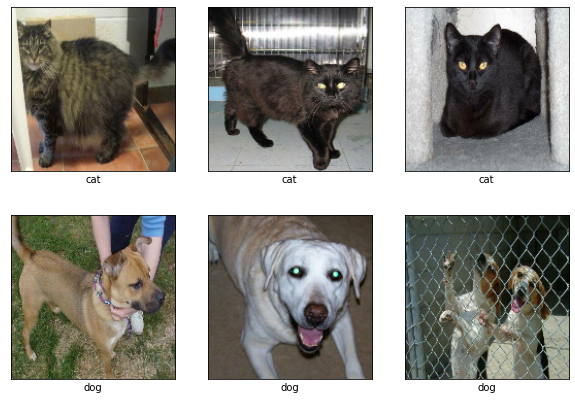

In [22]:
visualize(train_dataset)

### Checking the label frequencies

We'll create an iterator that will cycle through the labels and use it to get an array of labels

In [ ]:
labels_iterator= train_dataset.unbatch().map(lambda image, label: label).as_numpy_iterator()

#Use list comprehension over iterator to covert to array
labels = np.array([x for x in labels_iterator])

We can then use the array to count the number with each label.

In [ ]:
#Cats have a label of 0
n_cats = sum(labels == 0)

#Dogs have a label of 1
n_dogs = sum(labels == 1)
n_cats, n_dogs

(1000, 1000)

As the data has an equal number of cats and dogs, the baseline model would only be 50% accurate. 

## First Model

Our first model will use several layers:
- Conv2D performs convolution to extract features from the images
- MaxPooling2D summarize the data to reduce its size at each step
- Dropout drops some units during training to reduce overfitting
- Flatten flattens the data from 2D to 1D
- Dense is the similest layer athe heart of tensor flow and neural networks

In [ ]:
model1 = models.Sequential([
    #Alternate Conv2D and MaxPooling2D layers
    layers.Conv2D(64, (3, 3), activation='relu', ),
    layers.MaxPooling2D((2, 2)),

    #Add in a Dropout layer to reduce overfitting
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu'),

    #Flatten the data to prepare to use Dense
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(10)
])

Next we'll compile the model using adam as an optimizer.

In [ ]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Next we'll train the model on the dataset for twenty epochs, printing the results each time.

In [ ]:
history1 = model1.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 9s 127ms/step - loss: 0.7230 - accuracy: 0.5265 - val_loss: 2.2136 - val_accuracy: 0.5050
Epoch 2/20
63/63 [==============================] - 12s 180ms/step - loss: 0.7079 - accuracy: 0.5340 - val_loss: 2.0323 - val_accuracy: 0.5309
Epoch 3/20
63/63 [==============================] - 8s 122ms/step - loss: 0.7072 - accuracy: 0.5295 - val_loss: 2.0843 - val_accuracy: 0.5149
Epoch 4/20
63/63 [==============================] - 8s 116ms/step - loss: 0.6846 - accuracy: 0.5590 - val_loss: 1.7832 - val_accuracy: 0.5347
Epoch 5/20
63/63 [==============================] - 8s 113ms/step - loss: 0.6688 - accuracy: 0.5955 - val_loss: 1.5376 - val_accuracy: 0.5730
Epoch 6/20
63/63 [==============================] - 8s 115ms/step - loss: 0.6543 - accuracy: 0.6105 - val_loss: 1.5109 - val_accuracy: 0.5569
Epoch 7/20
63/63 [==============================] - 7s 114ms/step - loss: 0.6215 - accuracy: 0.6345 - val_loss: 1.2644 - val_accuracy: 0.5507
Epoch

Now let's visualize the results

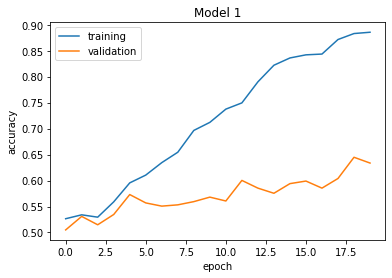

In [ ]:
plt.plot(history1.history["accuracy"], label = "training")
plt.plot(history1.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy", title = "Model 1")
plt.legend()

The accuracy of model 1 stabilized **between 59% and 63%** during training.  

This is better than the baseline of 50%, but still not that beneficial.

The data does appear to be overfit, with the training data having an accuracy of nearly 80%, but the accuracy is still slightly increasing on the validation dataset.

## 3 Data Augmentation

The flip layer flips an image in different orientations. Lets try it on a couple times on an image and see what it looks like.

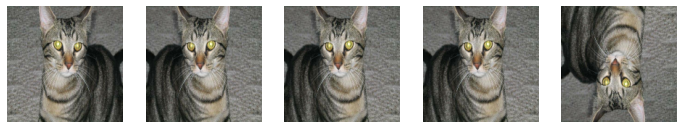

In [5]:
#Make the layer
flip = tf.keras.layers.RandomFlip()

#Make a figure
plt.figure(figsize=(12,5))

#Get the images and labels for the first batch of data
for images, labels in train_dataset.take(1):
  #We'll use the first image in the dataset
  image = images[0]

  #For 5 indicies
  for i in range(5):
    #Get the axis
    ax = plt.subplot(2,5,i+1)
    #If it's not the first (which we're keeping the same)
    if i > 0:
      #Flip it
      image = flip(image)
    #Display the image
    plt.imshow(image.numpy().astype('uint8'))
    plt.axis("off")

The rotate layer rotates the image a random number of degrees. We'll create a similar display for it

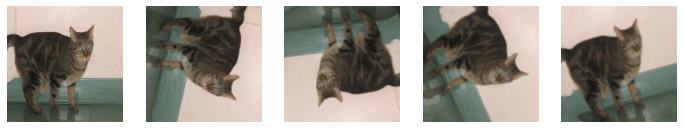

In [6]:
#Make a rotate layer
#The argument is the range of degrees to flip it, multiplied by pi
rotate = tf.keras.layers.RandomRotation((-1,1))

#Make another figure and do the same thing
plt.figure(figsize=(12,5))
for images, labels in train_dataset.take(1):
  image = images[0]
  for i in range(5):
    ax = plt.subplot(2,5,i+1)
    if i > 0:
      #Use rotate this time
      image = rotate(image)
    plt.imshow(image.numpy().astype('uint8'))
    plt.axis("off")

Now we'll make another model incorporating these layers and compile it

In [7]:
model2 = models.Sequential([
    #Add data augmentation layers
    layers.RandomFlip(),
    layers.RandomRotation((-1,1)),

    #The rest of the model is the same
    layers.Conv2D(64, (3, 3), activation='relu', ),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(10) 
])
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Now we'll train it, again for 20 epochs.

In [8]:
history2 = model2.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 21s 149ms/step - loss: 27.4879 - accuracy: 0.5090 - val_loss: 1.9692 - val_accuracy: 0.5124
Epoch 2/20
63/63 [==============================] - 10s 147ms/step - loss: 0.7463 - accuracy: 0.4895 - val_loss: 1.8112 - val_accuracy: 0.4790
Epoch 3/20
63/63 [==============================] - 7s 113ms/step - loss: 0.7405 - accuracy: 0.4975 - val_loss: 1.8224 - val_accuracy: 0.4901
Epoch 4/20
63/63 [==============================] - 7s 111ms/step - loss: 0.7192 - accuracy: 0.5185 - val_loss: 1.6957 - val_accuracy: 0.4864
Epoch 5/20
63/63 [==============================] - 7s 112ms/step - loss: 0.7252 - accuracy: 0.5000 - val_loss: 1.7348 - val_accuracy: 0.5124
Epoch 6/20
63/63 [==============================] - 7s 112ms/step - loss: 0.7091 - accuracy: 0.5335 - val_loss: 1.6756 - val_accuracy: 0.5433
Epoch 7/20
63/63 [==============================] - 7s 113ms/step - loss: 0.7018 - accuracy: 0.5285 - val_loss: 1.5446 - val_accuracy: 0.5681
Epo

And display our results.

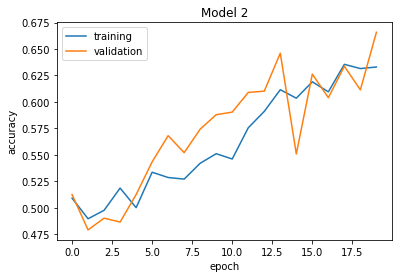

In [9]:
plt.plot(history2.history["accuracy"], label = "training")
plt.plot(history2.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy", title = "Model 2")
plt.legend()

The validation accuracy is **between 60% and 66%** during training.

This is slightly higher but still similar to what we achieved in model 1.

This time the model does not seem to be overfit, as the training and validation acucuracies are near each other.

## 4 Data Preprocessing

Now we're going to properly scale our data before training it. We'll normalize the RGB values between 0 and 1, instead of to 255.

In [10]:
i = tf.keras.Input(shape=(160, 160, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(i)

#Create a preprocessing layer
preprocessor = tf.keras.Model(inputs = [i], outputs = [x])

The next model will encourporate this layer along with everything else we had before.

In [19]:
model3 = models.Sequential([
                            
    #We add the preprocessing layer
    preprocessor,

    #But much of the rest is the same
    layers.RandomFlip(),
    layers.RandomRotation((-1,1)),
    layers.Conv2D(64, (3, 3), activation='relu', ),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),

    #With an additional dense layer to increase accuracy
    layers.Dense(64, activation='relu'),
    layers.Dense(10)
])

#Compile model
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Now we'll train our third model.

In [20]:
history3 = model3.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 9s 116ms/step - loss: 0.8453 - accuracy: 0.5055 - val_loss: 0.6683 - val_accuracy: 0.6200
Epoch 2/20
63/63 [==============================] - 7s 114ms/step - loss: 0.6724 - accuracy: 0.5715 - val_loss: 0.6708 - val_accuracy: 0.5495
Epoch 3/20
63/63 [==============================] - 7s 113ms/step - loss: 0.6566 - accuracy: 0.6015 - val_loss: 0.6310 - val_accuracy: 0.6572
Epoch 4/20
63/63 [==============================] - 7s 114ms/step - loss: 0.6421 - accuracy: 0.6130 - val_loss: 0.6198 - val_accuracy: 0.6634
Epoch 5/20
63/63 [==============================] - 7s 113ms/step - loss: 0.6247 - accuracy: 0.6435 - val_loss: 0.6292 - val_accuracy: 0.6250
Epoch 6/20
63/63 [==============================] - 8s 115ms/step - loss: 0.6058 - accuracy: 0.6545 - val_loss: 0.6353 - val_accuracy: 0.6324
Epoch 7/20
63/63 [==============================] - 7s 113ms/step - loss: 0.6034 - accuracy: 0.6735 - val_loss: 0.6004 - val_accuracy: 0.6671
Epoch 

And display our results

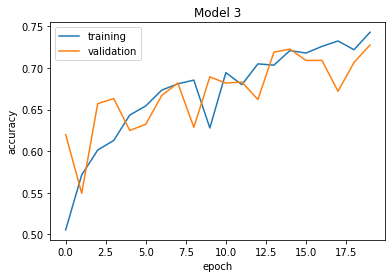

In [22]:
plt.plot(history3.history["accuracy"], label = "training")
plt.plot(history3.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy", title = "Model 3")
plt.legend()

The accuracy validation of our training model mostly stabilizes between 70% and 72%.

This is higher than our model 2, but we would still like it to be more accurate.

There does not seem to be overfitting, as the training and validation accuracy closely follow each other

## Transfer Learning

Previously we've used models that we've trained from scratch. But now we're going to use a model for image recognition that has already been built as a base model.

We'll download that here.


In [14]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

i = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(i, training = False)
base_model_layer = tf.keras.Model(inputs = [i], outputs = [x])

9420800/9406464 [==============================] - 0s 0us/step


For this model we'll use a simplfied version of our previous model and add in the layer for the base model.

In [15]:
model4 = models.Sequential([
                            
    #Use preprocessing layers
    preprocessor,

    #Data Augmentation layer
    layers.RandomFlip(),
    layers.RandomRotation((-1,1)),

    #Base modle layer
    base_model_layer,

    #Flatten the data to avoid an error
    layers.Flatten(),

    #And just one Dense layer to train the model for our purpose
    layers.Dense(2)
])

#And compile it
model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Let's look at the structure of our model.

In [16]:
model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 160, 160, 3)       0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 160, 160, 3)       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 160, 160, 3)      0         
 tation)                                                         
                                                                 
 model_1 (Functional)        (None, 5, 5, 1280)        2257984   
                                                                 
 flatten_2 (Flatten)         (None, 32000)             0         
                                                                 
 dense_4 (Dense)             (None, 2)                 64002     
                                                      

Now we'll look train this model.

In [17]:
history4 = model4.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 13s 119ms/step - loss: 0.8487 - accuracy: 0.8640 - val_loss: 0.1467 - val_accuracy: 0.9703
Epoch 2/20
63/63 [==============================] - 6s 90ms/step - loss: 0.6197 - accuracy: 0.9085 - val_loss: 0.3898 - val_accuracy: 0.9542
Epoch 3/20
63/63 [==============================] - 6s 89ms/step - loss: 0.6667 - accuracy: 0.9110 - val_loss: 0.3032 - val_accuracy: 0.9629
Epoch 4/20
63/63 [==============================] - 6s 89ms/step - loss: 0.6914 - accuracy: 0.9190 - val_loss: 0.2712 - val_accuracy: 0.9715
Epoch 5/20
63/63 [==============================] - 6s 88ms/step - loss: 0.5833 - accuracy: 0.9255 - val_loss: 0.3050 - val_accuracy: 0.9567
Epoch 6/20
63/63 [==============================] - 6s 89ms/step - loss: 0.4787 - accuracy: 0.9405 - val_loss: 0.2995 - val_accuracy: 0.9592
Epoch 7/20
63/63 [==============================] - 6s 89ms/step - loss: 0.8115 - accuracy: 0.9060 - val_loss: 0.2668 - val_accuracy: 0.9703
Epoch 8/20


Now let's visualize the accuracy

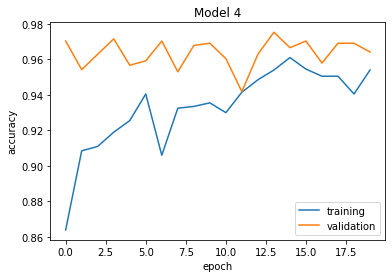

In [18]:
plt.plot(history4.history["accuracy"], label = "training")
plt.plot(history4.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy", title = "Model 4")
plt.legend()

The validation accuracy of our model is **between 95% and 97%**

This is by far the highest, nd it is high from the beginning.

The data is not overfit. In fact, the accuracy on the training data is below that of the validation data, due to dropout layers.

## 6 Score on Test Data

Our best model was model 4, so I'll use that to evaluate on the training data.

In [21]:
model4.evaluate(test_dataset)

6/6 [==============================] - 1s 104ms/step - loss: 0.8994 - accuracy: 0.9688


[0.8994154334068298, 0.96875]

We got an accuracy of 97%. We did well! 